In [56]:
import os
import sys
from pathlib import Path

import pkg_resources

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
installed_packages = [pkg.key for pkg in pkg_resources.working_set]
if "transformer-lens" not in installed_packages:
    %pip install transformer_lens==2.11.0 einops eindex-callum jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/ARENA_3.0-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [57]:
import functools
import sys
from pathlib import Path
from typing import Callable

import circuitsvis as cv
import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from eindex import eindex
from IPython.display import display
from jaxtyping import Float, Int
from torch import Tensor
from tqdm import tqdm
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
    utils,
)
from transformer_lens.hook_points import HookPoint

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part2_intro_to_mech_interp"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

import part2_intro_to_mech_interp.tests as tests
from plotly_utils import (
    hist,
    imshow,
    plot_comp_scores,
    plot_logit_attribution,
    plot_loss_difference,
)

# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

MAIN = __name__ == "__main__"

In [58]:
# for the first experiment im going to use gpt2-xl
device = "cuda" if t.cuda.is_available() else "cpu"
model = HookedTransformer.from_pretrained("gpt2-small").to(device)
print(model.cfg)

OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 11545 has 14.74 GiB memory in use. Of the allocated memory 14.21 GiB is allocated by PyTorch, and 409.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
numbers = [f" {i}" for i in range(1, 101)]
# tokenized = [model.to_str_tokens(n) for n in numbers]

# for n, toks in zip(numbers, tokenized):
#     print(n, "→", toks)

# The error `IndexError: too many indices for tensor of dimension 2` occurs because `cache['resid_post', layer]` is a 2-dimensional tensor,
# but the code attempts to index it with three dimensions `[:, number_pos, :]`.
# This can happen if `remove_batch_dim=True` implicitly flattens the batch and sequence dimensions.
# To fix this, we set `remove_batch_dim=False` (which is also the default).
# This ensures `cache['resid_post', layer]` always has 3 dimensions: `[batch_size, sequence_length, d_model]`,
# making the indexing `[:, number_pos, :]` valid.
logits, cache = model.run_with_cache(numbers, remove_batch_dim=False)
num_layers = model.cfg.n_layers

number_pos = 1
embeddings = []
for layer in range(num_layers):
    emb = cache['resid_post', layer][:, number_pos, :]
    embeddings.append(emb)

embeddings = t.stack(embeddings)
print(embeddings.shape)
print(embeddings[:1]) #embedded numbers from 1-100 and the residual stream here is composed of attention head outpurs and MLP outputs

torch.Size([48, 100, 1600])
tensor([[[-0.3433,  0.7334, -0.2215,  ..., -0.6734,  0.0229, -0.6794],
         [-0.2147,  0.8726, -0.5121,  ..., -0.3999,  0.1474, -0.1236],
         [-0.0793,  0.6393,  0.0800,  ..., -0.3033, -0.0049, -0.4062],
         ...,
         [-0.2060,  0.7062, -0.4170,  ...,  0.5073, -0.8208,  0.1590],
         [ 0.0938,  0.6716, -0.1336,  ...,  0.2343, -0.7062, -0.1790],
         [ 0.1671,  0.6806,  0.1280,  ...,  0.3937, -0.2275, -0.6007]]],
       device='cuda:0')


In [ ]:
numbers

[' 1',
 ' 2',
 ' 3',
 ' 4',
 ' 5',
 ' 6',
 ' 7',
 ' 8',
 ' 9',
 ' 10',
 ' 11',
 ' 12',
 ' 13',
 ' 14',
 ' 15',
 ' 16',
 ' 17',
 ' 18',
 ' 19',
 ' 20',
 ' 21',
 ' 22',
 ' 23',
 ' 24',
 ' 25',
 ' 26',
 ' 27',
 ' 28',
 ' 29',
 ' 30',
 ' 31',
 ' 32',
 ' 33',
 ' 34',
 ' 35',
 ' 36',
 ' 37',
 ' 38',
 ' 39',
 ' 40',
 ' 41',
 ' 42',
 ' 43',
 ' 44',
 ' 45',
 ' 46',
 ' 47',
 ' 48',
 ' 49',
 ' 50',
 ' 51',
 ' 52',
 ' 53',
 ' 54',
 ' 55',
 ' 56',
 ' 57',
 ' 58',
 ' 59',
 ' 60',
 ' 61',
 ' 62',
 ' 63',
 ' 64',
 ' 65',
 ' 66',
 ' 67',
 ' 68',
 ' 69',
 ' 70',
 ' 71',
 ' 72',
 ' 73',
 ' 74',
 ' 75',
 ' 76',
 ' 77',
 ' 78',
 ' 79',
 ' 80',
 ' 81',
 ' 82',
 ' 83',
 ' 84',
 ' 85',
 ' 86',
 ' 87',
 ' 88',
 ' 89',
 ' 90',
 ' 91',
 ' 92',
 ' 93',
 ' 94',
 ' 95',
 ' 96',
 ' 97',
 ' 98',
 ' 99',
 ' 100']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
%cd /content/drive/MyDrive/dataset

In [ ]:
#standard metrics used by the original authors
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import pairwise_distances
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind

def is_the_unique_min_num(num, num_list):
    return num == min(num_list) and list(num_list).count(num) == 1

def l2_distance(a, b):
    return np.linalg.norm(a - b)

def cos_distance(a, b):
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return 1 - cosine_similarity



def nearest_neighbor_analysis(num_z_c, num_labels, metric='euclidean'):
    """
    paramters:
    ----------------
    num_z_c: list of embeddings
    num_labels: list of number labels
    metric: str, optional, default 'euclidean'

    return:
    ----------------
    valid_nearest_neighbor_rate: the score of orderness
    """
    ascend_sorted_num_z, ascend_sorted_label = ascend_sort_embs(num_z_c, num_labels)
    distance_matrix = pairwise_distances(ascend_sorted_num_z, Y=None, metric=metric)
    valid_nearest_neighbor = 0
    total_num = 0
    for i in range(len(ascend_sorted_label)):
      left_neighbor_idx = i-1
      if left_neighbor_idx >= 0:
        total_num += 1
        left_neighbor_distance = distance_matrix[i, left_neighbor_idx]
        all_left_distances = distance_matrix[i, :i]
        if is_the_unique_min_num(left_neighbor_distance, all_left_distances):
          valid_nearest_neighbor += 1
      right_neighbor_idx = i+1
      if right_neighbor_idx <= len(ascend_sorted_label)-1:
        total_num += 1
        right_neighbor_distance = distance_matrix[i, right_neighbor_idx]
        all_right_distances = distance_matrix[i, i+1:]
        if is_the_unique_min_num(right_neighbor_distance, all_right_distances):
          valid_nearest_neighbor += 1
    return valid_nearest_neighbor / total_num

import matplotlib.pyplot as plt
from matplotlib import collections as matcoll


COLOR_LIST = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'hotpink', 'gray', 'steelblue', 'olive']


def plot_num_position_in_two_dim_repr(num_z, num_labels, fig_name, x_limit=None, y_limit=None, all_embs=None):
    plt.figure(figsize=(5, 5))
    assert len(num_z[0]) == 2, f"The representation dimension of a number should be two, but got {len(num_z[0])} instead."
    sorted_label = sorted(num_labels)
    sorted_indices = [i[0] for i in sorted(enumerate(num_labels), key=lambda x: x[1])]
    sorted_num_z = [num_z[i] for i in sorted_indices]
    X = [item[0] for item in sorted_num_z]
    Y = [item[1] for item in sorted_num_z]
    max_repeating_num = find_most_frequent_elements_repeating_num(num_labels)
    for i in range(0, len(num_z)):
        plt.scatter(X[i], Y[i],
                    marker=f'${sorted_label[i]}$',
                    s=200,
                    alpha=min(1, 1/max_repeating_num*1.3),
                    c=COLOR_LIST[sorted_label[i] % len(COLOR_LIST)])
        if all_embs is None:
            plt.grid(True)
    plt.plot(X, Y, linestyle='dashed', linewidth=0.5)
    if all_embs is not None:
        embs_x = [item[0] for item in all_embs]
        embs_y = [item[1] for item in all_embs]
        plt.scatter(embs_x, embs_y, marker='o', s=1, c='navy')
    plt.xlabel('z1')
    plt.ylabel('z2')
    if x_limit is not None:
        plt.xlim(x_limit[0], x_limit[1])
    if y_limit is not None:
        plt.ylim(y_limit[0], y_limit[1])
    if x_limit is None and y_limit is None:
        plt.axis('equal')

    plt.show()
    plt.savefig(fname=fig_name)


def find_most_frequent_elements_repeating_num(arr):
    nd_array = np.array(arr)
    unique_elements, counts = np.unique(nd_array, return_counts=True)
    max_count = np.max(counts)
    return max_count

def distance_linear_analysis(embs, labels):
    """
    paramters:
    ----------------
    embs: list of embeddings
    labels: list of number labels

    return:
    ----------------
    r2: the score of orderness
    k: the slope of the linear regression
    b: the intercept of the linear regression
    """
    dis_list, sort_label = gen_dis_list(embs, labels)
    r2, k, b = distance_linear_regression(dis_list, sort_label)
    return r2, k, b

def ascend_sort_embs(embs, labels):
    assert len(embs) == len(labels), f"embs and labels should have the same length, but got {len(embs)} and {len(labels)} instead."
    ascend_sorted_label = sorted(np.array(labels))
    ascend_sorted_indices = np.array([i[0] for i in sorted(enumerate(labels), key=lambda x: x[1])])
    ascend_sorted_num_z = np.array([embs[i] for i in ascend_sorted_indices])
    return ascend_sorted_num_z, ascend_sorted_label


def gen_dis_list(embs, labels):
    sort_emb, sort_label = ascend_sort_embs(embs, labels)
    dis_list = []
    for i in range(0, len(embs)-1):
        dis = np.linalg.norm(sort_emb[i] - sort_emb[i+1])
        dis_list.append(dis)
    return dis_list, sort_label[0:-1]


def distance_linear_regression(dists, labels):
    X = np.array(labels).reshape(-1, 1)
    y = np.array(dists)
    model = LinearRegression()
    model.fit(X, y)
    r2 = r2_score(y, model.predict(X))
    k = model.coef_[0]
    b = model.intercept_
    return r2, k, b

In [ ]:
orderness_per_layer = []
labels = list(range(1,101))
for layer in range(embeddings.shape[0]):
  embs = embeddings[layer].cpu().numpy()
  score = nearest_neighbor_analysis(embs,labels)
  orderness_per_layer.append(score)

orderness_per_layer = np.array(orderness_per_layer)
print(orderness_per_layer)

[0.80808081 0.78787879 0.77272727 0.78282828 0.77272727 0.77272727
 0.76767677 0.75757576 0.73737374 0.77777778 0.78282828 0.77272727
 0.78282828 0.78282828 0.78787879 0.81313131 0.81818182 0.8030303
 0.80808081 0.81313131 0.7979798  0.78787879 0.78787879 0.78282828
 0.78282828 0.77777778 0.74242424 0.71717172 0.71717172 0.70707071
 0.69191919 0.69191919 0.6969697  0.68686869 0.67171717 0.67171717
 0.65656566 0.64141414 0.62121212 0.60606061 0.61111111 0.6010101
 0.6010101  0.5959596  0.59090909 0.58585859 0.57575758 0.56565657]


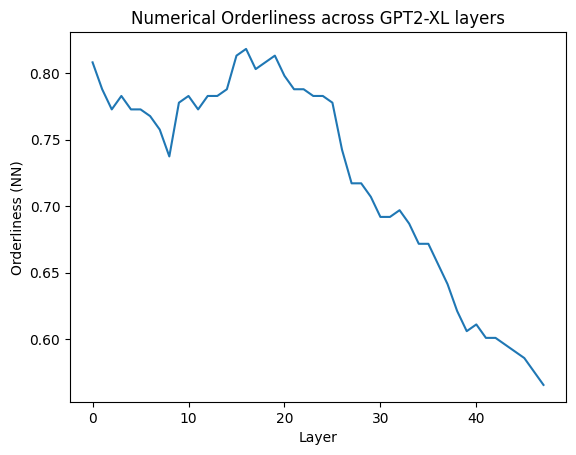

In [ ]:
import matplotlib.pyplot as plt

plt.plot(orderness_per_layer)
plt.xlabel("Layer")
plt.ylabel("Orderliness (NN)")
plt.title("Numerical Orderliness across GPT2-XL layers")
plt.show()


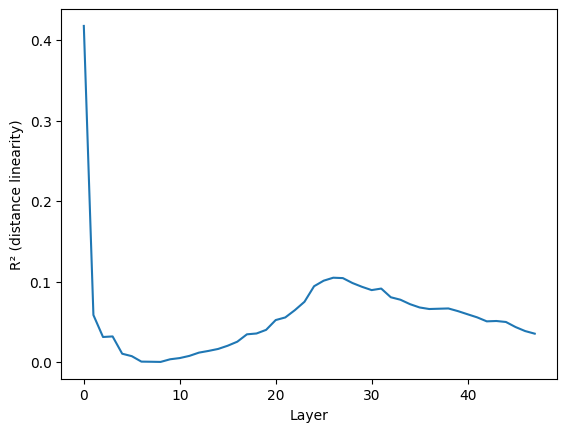

In [ ]:
r2_scores = []

for layer in range(embeddings.shape[0]):
    embs = embeddings[layer].cpu().numpy()
    r2, k, b = distance_linear_analysis(embs, labels)
    r2_scores.append(r2)

plt.plot(r2_scores)
plt.xlabel("Layer")
plt.ylabel("R² (distance linearity)")
plt.show()

In [ ]:
# lets check layer 15 pattern as it has the peak orderliness
layer15_pattern_from_cache = cache['pattern', 15]
q,k = cache['q', 15], cache['k', 15]
print(q.shape)
batch_size, seq, nhead, headsize = q.shape
layer15_attn_scores = einops.einsum(q,k, "b s_q n h, b s_k n h -> b n s_q s_k")
seq = q.shape[1]
mask = t.triu(t.ones((seq, seq), device=device, dtype=t.bool), diagonal=1)
layer15_attn_scores = layer15_attn_scores.masked_fill(mask,-1e9)
layer15_pattern_from_qk = (
    layer15_attn_scores / (headsize ** 0.5)
).softmax(dim=-1)
t.allclose(
    layer15_pattern_from_qk,
    layer15_pattern_from_cache,
    atol=1e-5
)


torch.Size([100, 2, 25, 64])


True

In [ ]:
# focus only on number token attending to previous tokens
number_pos = 1
attn = layer15_pattern_from_cache[:, :, number_pos, :]
attn

tensor([[[0.7815, 0.2185],
         [0.6267, 0.3733],
         [0.9865, 0.0135],
         ...,
         [0.9729, 0.0271],
         [0.8833, 0.1167],
         [0.9305, 0.0695]],

        [[0.8715, 0.1285],
         [0.7201, 0.2799],
         [0.9703, 0.0297],
         ...,
         [0.8671, 0.1329],
         [0.9040, 0.0960],
         [0.7061, 0.2939]],

        [[0.8568, 0.1432],
         [0.7110, 0.2890],
         [0.9779, 0.0221],
         ...,
         [0.8274, 0.1726],
         [0.9115, 0.0885],
         [0.6506, 0.3494]],

        ...,

        [[0.9426, 0.0574],
         [0.6411, 0.3589],
         [0.9903, 0.0097],
         ...,
         [0.9332, 0.0668],
         [0.9188, 0.0812],
         [0.9363, 0.0637]],

        [[0.8877, 0.1123],
         [0.4398, 0.5602],
         [0.9911, 0.0089],
         ...,
         [0.9159, 0.0841],
         [0.8642, 0.1358],
         [0.8493, 0.1507]],

        [[0.8814, 0.1186],
         [0.5911, 0.4089],
         [0.9919, 0.0081],
         ...,
 

In [ ]:
labels = list(range(1, 101))
number_pos = 1

head_orderness = {}

for layer in range(model.cfg.n_layers):
    head_orderness[layer] = {}
    for head in range(model.cfg.n_heads):
        z = cache["z", layer][:, number_pos, head, :]   # [batch, d_head]
        W_O = model.W_O[layer][head]                     # [d_head, d_model]
        head_embs = z @ W_O                              # [batch, d_model]

        score = nearest_neighbor_analysis(
            head_embs.cpu().numpy(),
            labels
        )

        head_orderness[layer][head] = score

In [ ]:
ranked = sorted(
    [(layer, head, score)
     for layer in head_orderness
     for head, score in head_orderness[layer].items()],
    key=lambda x: x[2],
    reverse=True
)

for l, h, s in ranked[:20]:
    print(f"L{l}H{h}: {s:.3f}")


L14H19: 0.732
L14H16: 0.727
L18H15: 0.717
L21H23: 0.707
L25H24: 0.692
L23H22: 0.687
L31H2: 0.687
L21H15: 0.672
L13H8: 0.657
L26H14: 0.657
L9H18: 0.641
L2H7: 0.626
L11H20: 0.621
L3H5: 0.616
L9H16: 0.616
L15H17: 0.611
L4H15: 0.601
L8H12: 0.596
L6H4: 0.591
L12H13: 0.591


In [ ]:
tokens = model.to_str_tokens(numbers)
layer = 15
attention_pattern = cache['pattern', layer] #[batch, heads, seq, seq]
heads = [19]
attention_subset = attention_pattern[:, heads, :, :]
import circuitsvis as cv
from IPython.display import display

display(
    cv.attention.attention_patterns(
        tokens=tokens,
        attention=attention_subset,
        attention_head_names=[f"L{layer}H{h}" for h in heads],
    )
)

In [ ]:
def make_number_sequences(n=20): #changed n from 100 to 20 to avoid gpu issues for the patching experiment at the bottom
    return [" ".join(str(i+j) for j in range(5)) for i in range(1, n-5)]
make_number_sequences()

['1 2 3 4 5',
 '2 3 4 5 6',
 '3 4 5 6 7',
 '4 5 6 7 8',
 '5 6 7 8 9',
 '6 7 8 9 10',
 '7 8 9 10 11',
 '8 9 10 11 12',
 '9 10 11 12 13',
 '10 11 12 13 14',
 '11 12 13 14 15',
 '12 13 14 15 16',
 '13 14 15 16 17',
 '14 15 16 17 18']

In [ ]:
texts = make_number_sequences()
logits, cache = model.run_with_cache(texts, remove_batch_dim=False)
layer = 0
print(cache["pattern", layer].shape)


torch.Size([94, 25, 6, 6])


In [ ]:
def adjacency_bias(cache, layer, head):
    attn = cache["pattern", layer][:, head]  # [batch, seq, seq]
    seq = attn.shape[1]

    if seq < 4:
        return np.nan

    scores = []

    for b in range(attn.shape[0]):
        for pos in range(2, seq - 1):
            scores.append(
                (attn[b, pos, pos - 1] + attn[b, pos, pos + 1]).item()
            )

    return np.mean(scores)


all_adjacency_scores = []

for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        score = adjacency_bias(cache, layer, head)
        all_adjacency_scores.append((layer, head, score))

# Sort the scores in descending order
all_adjacency_scores.sort(key=lambda x: -x[2])

print("Top 20 Heads by Adjacency Bias:")
for l, h, s in all_adjacency_scores[:20]:
    print(f"L{l}H{h}: {s:.3f}")

Top 20 Heads by Adjacency Bias:
L15H19: 0.995
L14H12: 0.976
L13H20: 0.955
L12H21: 0.947
L4H18: 0.906
L16H5: 0.833
L11H2: 0.829
L9H7: 0.725
L18H1: 0.677
L17H9: 0.655
L19H12: 0.616
L14H20: 0.585
L19H1: 0.574
L22H5: 0.559
L10H10: 0.489
L10H15: 0.473
L14H10: 0.468
L6H1: 0.460
L10H13: 0.450
L9H18: 0.450


## ahh hmm above its kinda impractical to visualize the heads as its too big to display

so how bout if we try to see the adjacency bias like when processing number n how much attention mass goes to n-1 and n+1

In [ ]:
def adjacency_bias(cache, layer, head, number_pos=1):
    attn = cache["pattern", layer]          # [batch, heads, seq, seq]
    attn = attn[:, head, number_pos, :]     # [batch, seq]

    # positions: 0 = BOS, 1 = number
    # adjacency in *batch index space*
    adj_scores = []

    for i in range(1, attn.shape[0] - 1):
        left = attn[i, 0]   # BOS (proxy for n-1 in isolated setting)
        right = attn[i, 1]  # self
        adj_scores.append(left + right)

    return np.mean(adj_scores)
head_scores = []

for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        score = adjacency_bias(cache, layer, head)
        head_scores.append((layer, head, score))

head_scores.sort(key=lambda x: -x[2])
head_scores[:20]

In [ ]:
def make_number_sequences(n=100):
    return [" ".join(str(i+j) for j in range(5)) for i in range(1, n-5)]

texts = make_number_sequences()
logits, cache = model.run_with_cache(texts)
tokens = model.to_str_tokens(texts)
def adjacency_bias(cache, layer, head):
    attn = cache["pattern", layer]   # [batch, heads, seq, seq]
    attn = attn[:, head]             # [batch, seq, seq]

    scores = []

    for b in range(attn.shape[0]):
        for pos in range(2, attn.shape[1] - 1):  # skip BOS
            left = attn[b, pos, pos-1]
            right = attn[b, pos, pos+1]
            scores.append(left + right)

    return np.mean(scores)


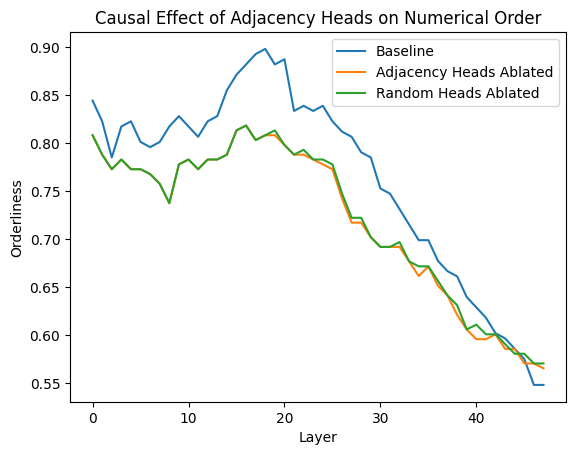

In [ ]:
import random
top_adj_heads = {
    14: [19],
    13: [20],
    12: [21],
    15: [19],
}

from functools import partial

patched_cache = {}

def cache_and_ablate_z(z, hook, heads_to_ablate):
    # store activation
    patched_cache[hook.name] = z.detach()

    # ablate
    z = z.clone()
    z[:, :, heads_to_ablate, :] = 0.0
    return z


def cache_resid_post(resid, hook):
    patched_cache[hook.name] = resid.detach()
    return resid

def run_head_ablation(model, texts, heads_by_layer):
    patched_cache.clear()
    fwd_hooks = []

    for layer, heads in heads_by_layer.items():
        hook_name = f"blocks.{layer}.attn.hook_z"
        fwd_hooks.append(
            (hook_name, partial(cache_and_ablate_z, heads_to_ablate=heads))
        )
    for layer in range(model.cfg.n_layers):
      fwd_hooks.append(
          (f"blocks.{layer}.hook_resid_post", cache_resid_post)
      )

    model.run_with_hooks(
        texts,
        return_type=None,
        fwd_hooks=fwd_hooks
    )

    return patched_cache



def compute_orderness_from_cache(cache, model, number_pos=1):
    batch_size = cache["resid_post", 0].shape[0]
    labels = list(range(1, batch_size + 1))  # 🔑 FIX

    embeddings = []
    for layer in range(model.cfg.n_layers):
        emb = cache["resid_post", layer][:, number_pos, :]
        embeddings.append(emb.cpu())

    embeddings = t.stack(embeddings)

    orderness = []
    for layer in range(embeddings.shape[0]):
        score = nearest_neighbor_analysis(
            embeddings[layer].numpy(),
            labels
        )
        orderness.append(score)

    return np.array(orderness)
def compute_orderness_from_patched_cache(patched_cache, model, number_pos=1):
    layers = model.cfg.n_layers
    batch_size = list(patched_cache.values())[0].shape[0]
    labels = list(range(1, batch_size + 1))

    orderness = []

    for layer in range(layers):
        key = f"blocks.{layer}.hook_resid_post"
        emb = patched_cache[key][:, number_pos, :].cpu().numpy()
        score = nearest_neighbor_analysis(emb, labels)
        orderness.append(score)

    return np.array(orderness)
baseline_orderness = compute_orderness_from_cache(cache, model)

adj_cache = run_head_ablation(model, numbers, top_adj_heads)
adj_orderness = compute_orderness_from_patched_cache(adj_cache, model)

random_heads = {
    layer: random.sample(range(model.cfg.n_heads), 1)
    for layer in top_adj_heads
}

rand_cache = run_head_ablation(model, numbers, random_heads)
rand_orderness = compute_orderness_from_patched_cache(rand_cache, model)

plt.plot(baseline_orderness, label="Baseline")
plt.plot(adj_orderness, label="Adjacency Heads Ablated")
plt.plot(rand_orderness, label="Random Heads Ablated")
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Orderliness")
plt.title("Causal Effect of Adjacency Heads on Numerical Order")
plt.show()


In [ ]:
clean_numbers = make_number_sequences()
import random

def corrupt_sequences(texts):
    corrupted = []
    for t in texts:
        toks = t.split()
        random.shuffle(toks)
        corrupted.append(" ".join(toks))
    return corrupted

corrupted_numbers = corrupt_sequences(clean_numbers)
corrupted_numbers[:5]

['3 2 4 5 1', '5 3 2 6 4', '6 7 3 4 5', '6 7 5 4 8', '5 6 9 7 8']

In [ ]:
clean_numbers[:5]

['1 2 3 4 5', '2 3 4 5 6', '3 4 5 6 7', '4 5 6 7 8', '5 6 7 8 9']

In [ ]:
clean_logits, clean_cache = model.run_with_cache(
    clean_numbers,
    remove_batch_dim=False
)

corr_logits, corr_cache = model.run_with_cache(
    corrupted_numbers,
    remove_batch_dim=False
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 11545 has 14.74 GiB memory in use. Of the allocated memory 14.21 GiB is allocated by PyTorch, and 409.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)